# Advanced Ethereum Price Forecasting with ARIMA and auto_arima

## Introduction
In this notebook, we forecast the price of Ethereum (ETH/USD) using advanced time series techniques. We will download historical price data, perform exploratory data analysis (EDA), check and enforce stationarity, and build an ARIMA model with automated hyperparameter tuning using `auto_arima` from `pmdarima`.

## Scope
- **Data Collection:** Retrieve ETH/USD historical data using `yfinance`.
- **Exploratory Data Analysis:** Visualize trends, rolling statistics, and descriptive statistics.
- **Stationarity Testing:** Use the Augmented Dickey-Fuller (ADF) test and apply differencing.
- **ACF and PACF Analysis:** Identify autoregressive and moving average components.
- **Advanced ARIMA Modeling:** Use `auto_arima` for automatic parameter tuning.
- **Forecasting:** Forecast the next 30 days and evaluate performance.
- **Visualization:** Create clear, robust visualizations of historical data, forecasts, and diagnostics.

In [ ]:
!pip uninstall -y numpy pmdarima
!pip install numpy==1.23.5
!pip install pmdarima --no-cache-dir

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 88.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.0 MB/s eta 0:00:00


This cell imports all necessary libraries for data manipulation, visualization, time series analysis, and model evaluation.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import yfinance as yf

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

print("All libraries imported successfully!")


All libraries imported successfully!


In this cell, we define our ticker and time range, then download and preprocess the ETH/USD data using yfinance. We convert the Date column into a datetime format and set it as the index.


In [ ]:

ticker = "ETH-USD"        
start_date = "2016-01-01"  
end_date = "2025-01-01"     

data = yf.download(ticker, start=start_date, end=end_date)

data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

print("First five rows of the dataset:")
print(data.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


First five rows of the dataset:
Price             Open        High         Low       Close      Volume
Ticker         ETH-USD     ETH-USD     ETH-USD     ETH-USD     ETH-USD
Date                                                                  
2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984
2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984
2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992
2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936
2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984


Here we visualize the ETH/USD closing prices over time. We plot the raw closing price, and then compute and plot a 30-day rolling mean and standard deviation to assess trends and volatility in the data.

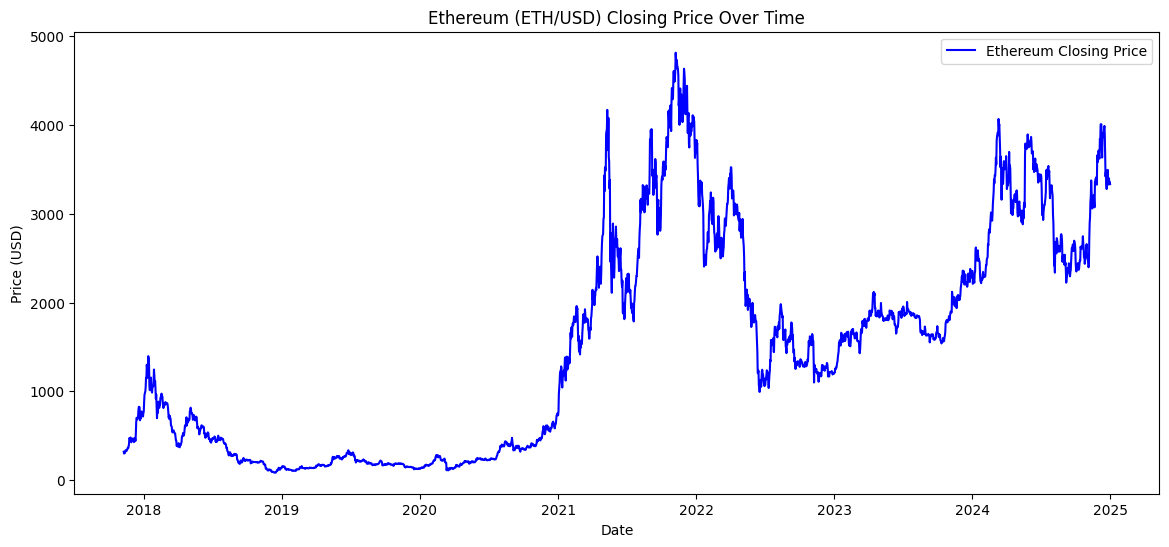

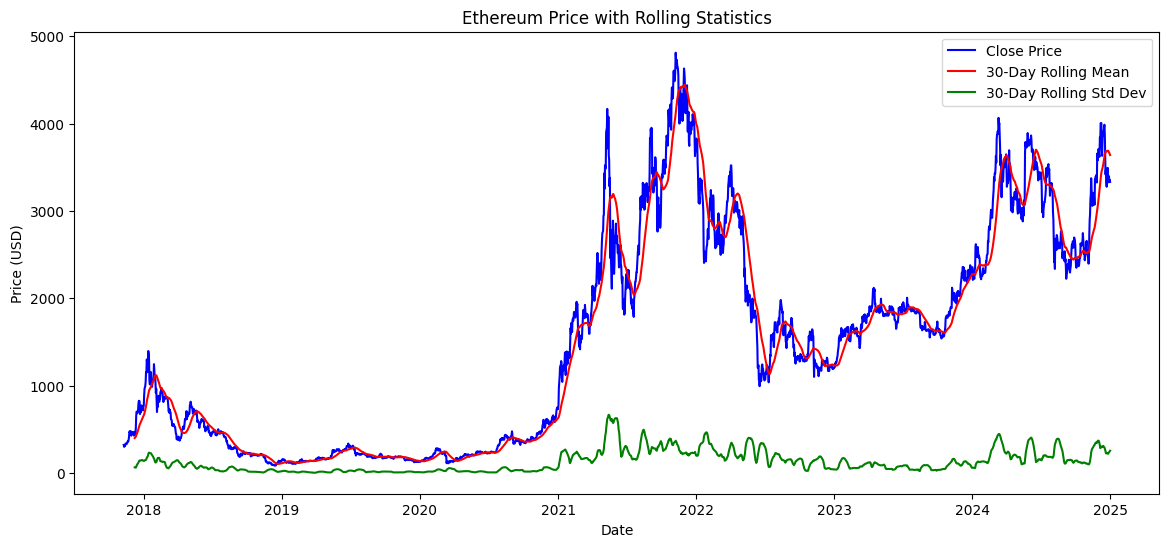

Statistical Summary:
Price         Close  RollingMean   RollingStd
Ticker      ETH-USD                          
count   2610.000000  2581.000000  2581.000000
mean    1491.479418  1486.351445   127.207926
std     1226.561428  1208.415089   123.086622
min       84.308296   103.516528     2.944659
25%      268.782860   257.654576    28.147747
50%     1354.947632  1406.991174    88.816201
75%     2412.390747  2453.859139   190.572928
max     4812.087402  4442.874154   666.054825


In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Ethereum Closing Price', color='blue')
plt.title('Ethereum (ETH/USD) Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

data['RollingMean'] = data['Close'].rolling(window=30).mean()
data['RollingStd'] = data['Close'].rolling(window=30).std()

plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['RollingMean'], label='30-Day Rolling Mean', color='red')
plt.plot(data['RollingStd'], label='30-Day Rolling Std Dev', color='green')
plt.title('Ethereum Price with Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

print("Statistical Summary:")
print(data[['Close', 'RollingMean', 'RollingStd']].describe())


This cell defines a helper function to perform the Augmented Dickey-Fuller (ADF) test, which checks the stationarity of a time series. We then run the test on the original closing price series.


In [ ]:
def adf_test(series):
    print("Running Augmented Dickey-Fuller Test...")
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    if result[1] <= 0.05:
        print("The series is likely stationary.")
    else:
        print("The series is likely non-stationary.")

print("ADF Test on Original Closing Price:")
adf_test(data['Close'])


ADF Test on Original Closing Price:
Running Augmented Dickey-Fuller Test...
ADF Statistic                    -1.324097
p-value                           0.618077
# Lags Used                      17.000000
Number of Observations Used    2592.000000
Critical Value (1%)              -3.432875
Critical Value (5%)              -2.862656
Critical Value (10%)             -2.567364
dtype: float64
The series is likely non-stationary.


Since the ADF test on the original series may indicate non-stationarity, we apply first-order differencing. We then test the differenced series and plot it to confirm if stationarity is achieved.


ADF Test on First-Order Differenced Series:
Running Augmented Dickey-Fuller Test...
ADF Statistic                 -1.270795e+01
p-value                        1.045144e-23
# Lags Used                    1.600000e+01
Number of Observations Used    2.592000e+03
Critical Value (1%)           -3.432875e+00
Critical Value (5%)           -2.862656e+00
Critical Value (10%)          -2.567364e+00
dtype: float64
The series is likely stationary.


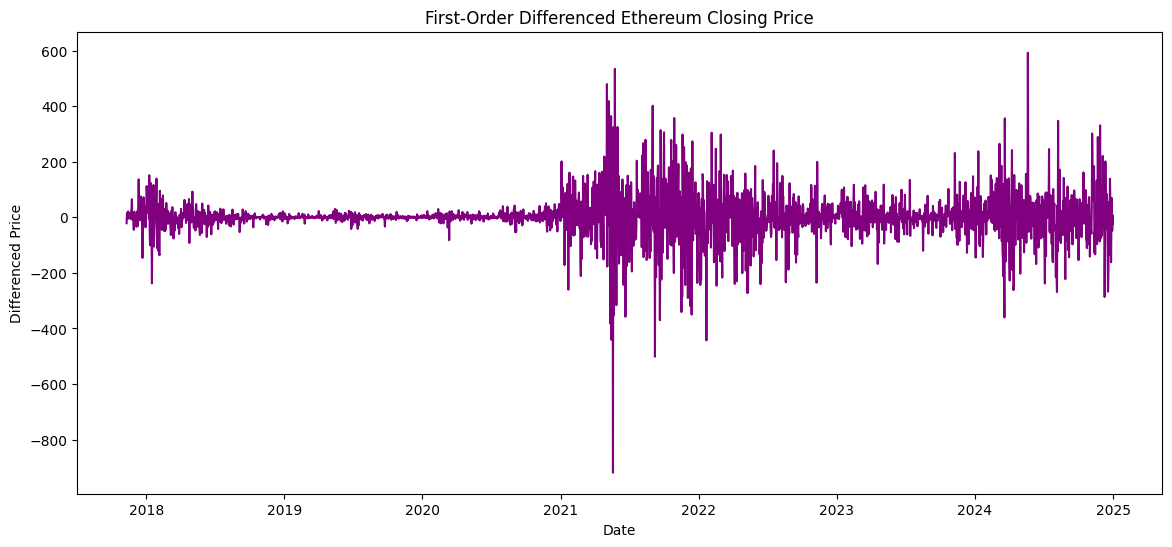

In [ ]:

data['Close_diff'] = data['Close'].diff()

data_diff = data['Close_diff'].dropna()

print("ADF Test on First-Order Differenced Series:")
adf_test(data_diff)

plt.figure(figsize=(14, 6))
plt.plot(data_diff, color='purple')
plt.title('First-Order Differenced Ethereum Closing Price')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.show()

In this cell, we plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for the differenced series to help determine the orders of the AR (p) and MA (q) components of the ARIMA model.


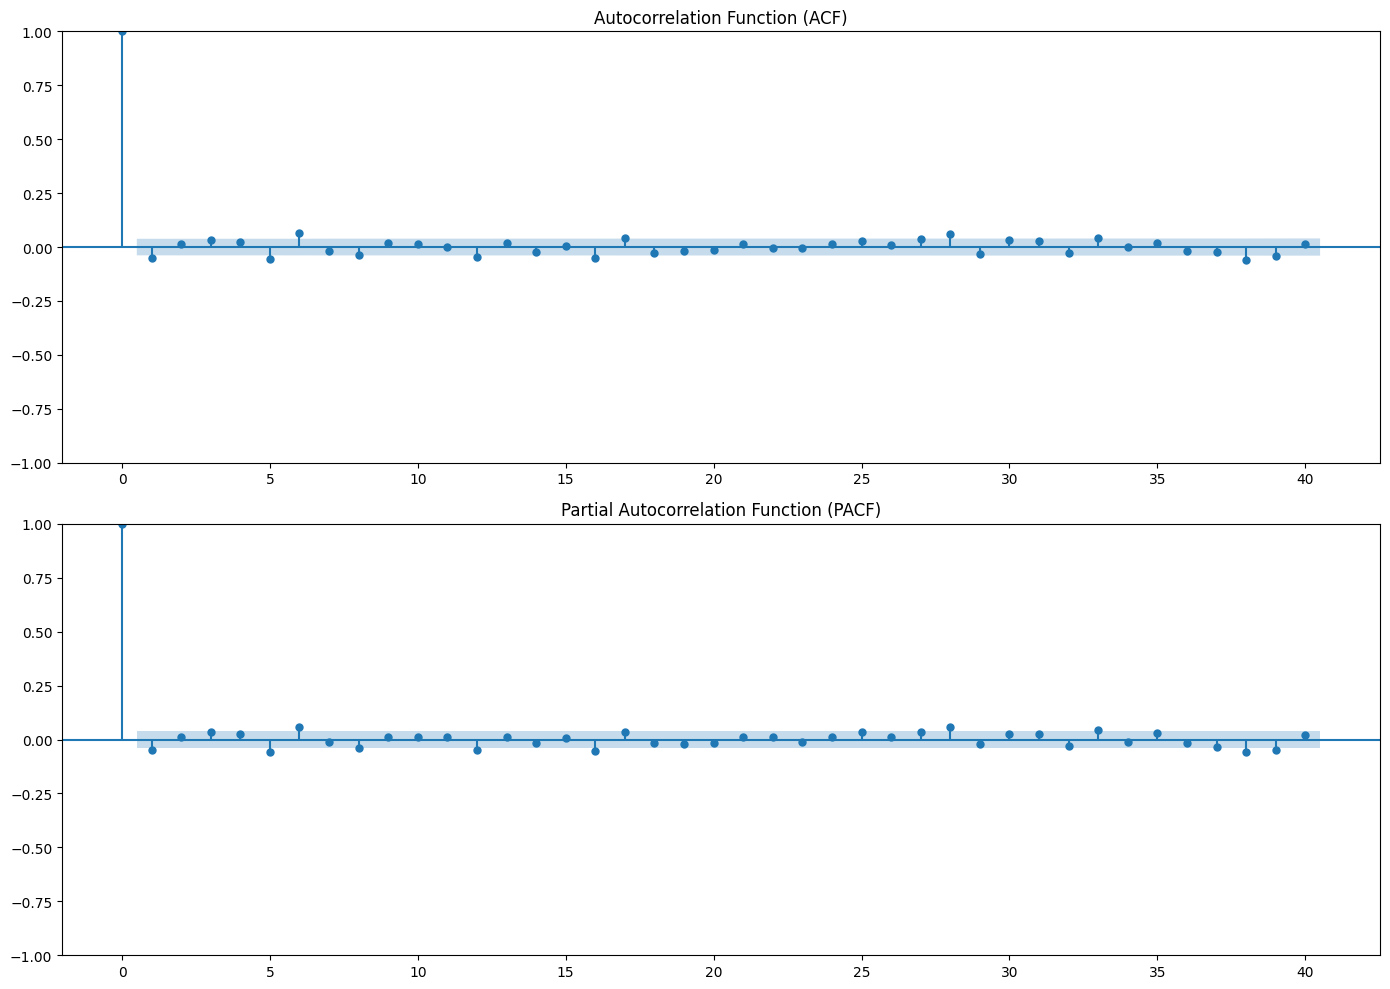

In [ ]:

fig, ax = plt.subplots(2, 1, figsize=(14, 10))

plot_acf(data_diff, lags=40, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(data_diff, lags=40, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

Instead of manually choosing ARIMA parameters, we now use auto_arima from the pmdarima library. auto_arima tests multiple combinations of parameters (p, d, q) and selects the best model based on AIC. We will fit the model on the full closing price series.

In [ ]:

model_auto = auto_arima(data['Close'],        
                        start_p=0, start_q=0,      
                        max_p=5, max_q=5,       
                        d=1,                       
                        seasonal=False,           
                        trace=True,                 
                        error_action='ignore',      
                        suppress_warnings=True,
                        stepwise=True)

print("Best ARIMA model parameters (p, d, q):", model_auto.order)

model_auto_fit = model_auto.fit(data['Close'])
print(model_auto_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30221.352, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30216.645, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30216.843, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30219.906, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=30218.283, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=30218.494, Time=1.89 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=30218.457, Time=5.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=30215.259, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=30216.883, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=30217.098, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=30215.456, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=30217.002, Time=0.61 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 10.215 seconds
Best ARIMA model parameters (p, d, q): (1, 1, 0)
                          

With the best ARIMA model identified and fitted, we forecast the next 30 days of Ethereum prices. We also compute evaluation metrics using a train-test split and visualize the forecast along with the historical data and prediction intervals.

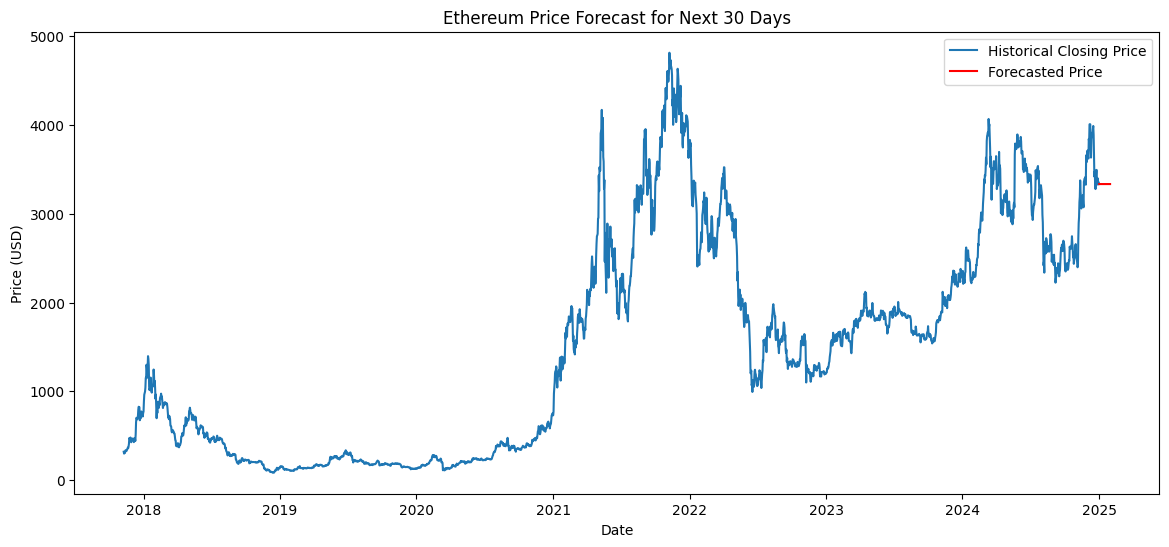

RMSE on Test Data: 260.0145966247053
MAPE on Test Data: 6.58%


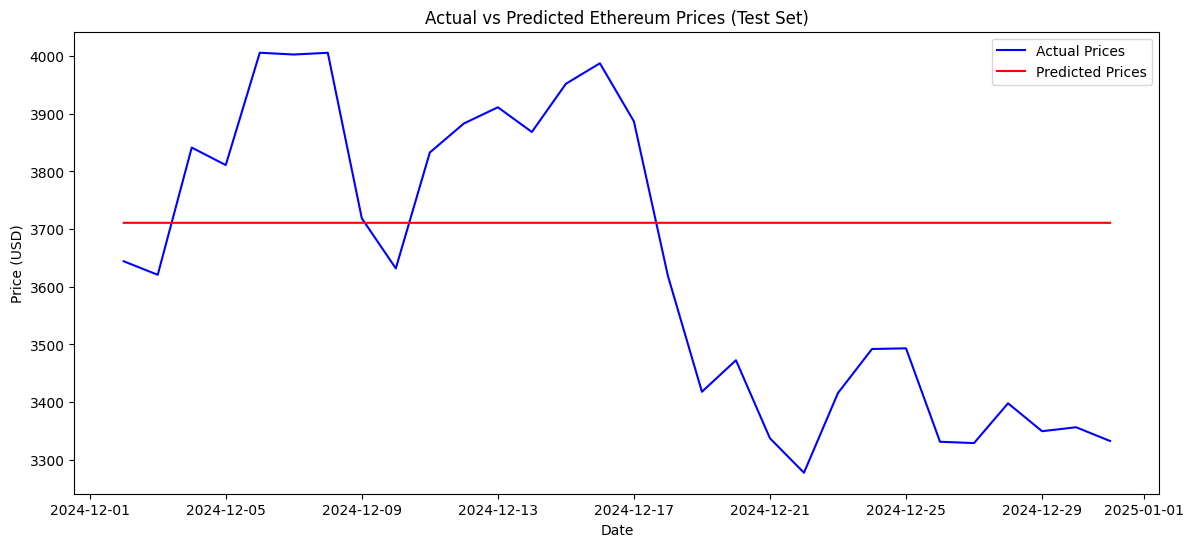

In [ ]:

forecast_steps = 30
forecast_result = model_auto_fit.predict(n_periods=forecast_steps)
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_series = pd.Series(forecast_result, index=forecast_index)

plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Historical Closing Price')
plt.plot(forecast_series, label='Forecasted Price', color='red')
plt.title('Ethereum Price Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

train_size = len(data) - 30
train_data = data['Close'][:train_size]
test_data = data['Close'][train_size:]

model_train = auto_arima(train_data,
                         start_p=0, start_q=0,
                         max_p=5, max_q=5,
                         d=1,
                         seasonal=False,
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

predicted = model_train.predict(n_periods=30)
predicted_series = pd.Series(predicted, index=test_data.index)

rmse = np.sqrt(mean_squared_error(test_data, predicted_series))
mape = mean_absolute_percentage_error(test_data, predicted_series)

print(f'RMSE on Test Data: {rmse}')
print(f'MAPE on Test Data: {mape * 100:.2f}%')

plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data, label='Actual Prices', color='blue')
plt.plot(predicted_series.index, predicted_series, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Ethereum Prices (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Conclusion

In this notebook, we:
- **Collected** Ethereum (ETH/USD) price data using yfinance.
- **Conducted EDA** to understand trends and volatility through rolling statistics.
- **Tested for stationarity** using the Augmented Dickey-Fuller test and applied first-order differencing.
- **Visualized ACF and PACF** plots to guide parameter selection.
- **Utilized auto_arima** for advanced, automated tuning of ARIMA parameters, leading to an optimized model.
- **Forecasted** Ethereum prices for the next 30 days, and evaluated the model using RMSE and MAPE metrics.

## Next Steps
- **Further Tuning:** Consider extending the range of parameters or incorporating seasonal models (e.g., SARIMA) if seasonality is significant.
- **Advanced Visualizations:** Use interactive visualization libraries (e.g., Plotly) to build dashboards for deeper insights.
- **Alternative Models:** Experiment with machine learning or deep learning models like LSTM networks for potentially better performance on highly volatile time series.